In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import scipy.linalg as sl
import scipy.stats as ss
import scipy.spatial as ssp
import numpy as np
import math
import pickle

from copy import deepcopy
import itertools
import tqdm

# additionally requires libcpab (https://github.com/SkafteNicki/libcpab)
import nwarp

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
def augment_cps(cps):
    return np.concatenate(([0], cps, [T])).astype(int)

def hausdorff(cps1, cps2):
    """The provided cps must NOT include 0 and T."""
    return max(
        ssp.distance.directed_hausdorff(cps1.reshape(-1, 1), cps2.reshape(-1, 1))[0],
        ssp.distance.directed_hausdorff(cps2.reshape(-1, 1), cps1.reshape(-1, 1))[0]
    )

def compute_frobenius_matrix(cps):
    """The provided cps MUST include 0 and T."""
    T = cps[-1]
    timestep_to_segment = (
        (cps[:-1] <= np.tile(np.linspace(0, T-1, T).reshape(-1,1), len(cps)-1)) &
        (np.tile(np.linspace(0, T-1, T).reshape(-1,1), len(cps)-1) < cps[1:])
    )
    timesteps_in_same_segment = np.matmul(timestep_to_segment, timestep_to_segment.transpose())
    frobenius = timestep_to_segment/np.sqrt(np.tile(timestep_to_segment.sum(axis=0).reshape(-1, 1), T).transpose())
    frobenius = np.matmul(frobenius, frobenius.transpose())
    return frobenius

def frobenius(cps1, cps2, m1=None, m2=None):
    """The provided cps must NOT include 0 and T."""
    if m1 is None:
        m1 = compute_frobenius_matrix(augment_cps(cps1))
    if m2 is None:
        m2 = compute_frobenius_matrix(augment_cps(cps2))
    return sl.norm(m1 - m2, 'fro')

In [12]:
def iidsample_with_cps(cps, dists):
    #for d in dists:
    #    print(f'{d.mean():5.2f}\t{d.var():5.2f}')
    sample = np.empty(cps[-1])
    olddist = None
    dist = np.random.choice(dists)
    for k in range(len(cps)-1):
        while olddist == dist:
            dist = np.random.choice(dists)
        sample[cps[k]:cps[k+1]] = dist.rvs(cps[k+1]-cps[k])
        olddist = dist
    return sample

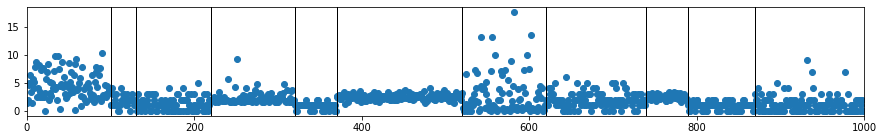

In [3]:
# Arlot2019 scenario 1
cps = np.array([0, 100, 130, 220, 320, 370, 520, 620, 740, 790, 870, 1000], dtype=int)
dists = [
    ss.binom(10, 0.2),
    ss.nbinom(3, 0.7),
    ss.hypergeom(10, 5, 2),
    ss.norm(2.5, scale=np.sqrt(0.25)),
    ss.gamma(0.5, scale=5),
    ss.weibull_min(2, scale=5),
    ss.pareto(3, scale=1.5)
]

T = cps[-1]
K = len(cps)-1

sample = iidsample_with_cps(cps, dists)

plt.figure(figsize=(15,2))
plt.scatter(range(cps[-1]), sample)
for cp in cps[1:-1]:
    plt.axvline(cp, lw=1, color='black')
plt.xlim(0, cps[-1])
plt.show()

# Segmented model estimation

### Define model

In [5]:
# PIECEWISE GAUSSIAN MODEL (sensitive to changes in mean and variance)
# TSP-based parameter warping with constant mode vector

Dparamg = 0 # number of global parameters (same in every segment)
Dparaml = 2 # number of local parameters (different in every segment)

paramwarpTSPB = nwarp.ParameterWarp(
    K, Dparamg, Dparaml,
    nwarp.TSPStepWarp(nwarp.Constant((K-1,)),
                      width=0.125, power=16.,
                      min_step=0.0001, max_step=0.9999),
    verbose=False
)

paramwarpVanilla = nwarp.ParameterWarp(
    K, Dparamg, Dparaml,
    nwarp.VanillaWarp(nwarp.Constant((T-1,)), nonneg_trans='square'),
    verbose=False
)

paramwarpCPAB = nwarp.ParameterWarp(
    K, Dparamg, Dparaml,
    nwarp.CPABWarp(K+1, nwarp.Constant((K,))),
    verbose=False
)

model = nwarp.NormalDistribution()

### Training and Evaluation

In [6]:
x_train = torch.Tensor(iidsample_with_cps(cps, dists)).reshape(1, -1, 1)

In [7]:
n_restarts    =  10 # number of randomized restarts
n_epochs      = 300 # total number of epochs per restart
n_epochs_hard = 100 # use hard segmentation for the last X epochs
lr            = 1e-1
loss_fn       = nn.MSELoss()
paramwarp     = paramwarpTSPB
show_plots    = True

print(model)
paramwarp.train()

NormalDistribution()


ParameterWarp(
  (warp): TSPStepWarp(
    (loc_net): Constant()
  )
  (resample): Resample()
)

restart  1/10: 100%|██████████| 300/300 [00:01<00:00, 177.31it/s, max=4.4681, cur=1.4688]


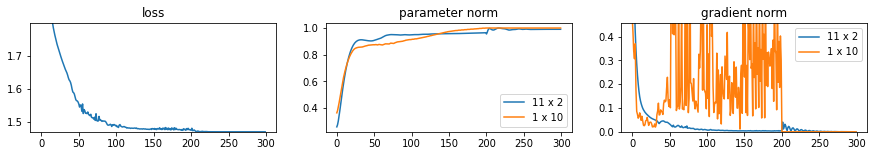

restart  2/10: 100%|██████████| 300/300 [00:01<00:00, 184.33it/s, max=4.5742, cur=1.4290]


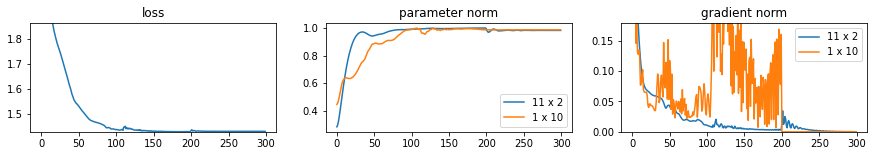

restart  3/10: 100%|██████████| 300/300 [00:01<00:00, 175.82it/s, max=3.4459, cur=1.5621]


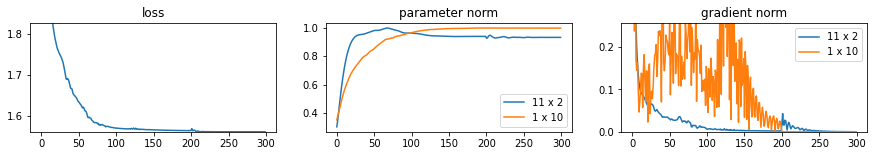

restart  4/10: 100%|██████████| 300/300 [00:01<00:00, 185.99it/s, max=3.8600, cur=1.5091]


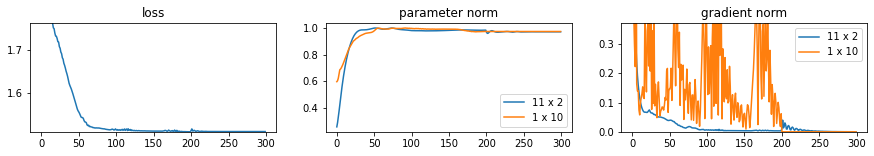

restart  5/10: 100%|██████████| 300/300 [00:01<00:00, 184.00it/s, max=4.9252, cur=1.4925]


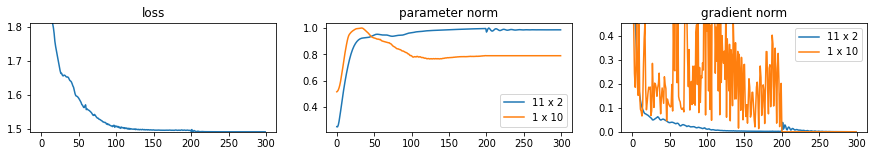

restart  6/10: 100%|██████████| 300/300 [00:01<00:00, 175.79it/s, max=4.1195, cur=1.5470]


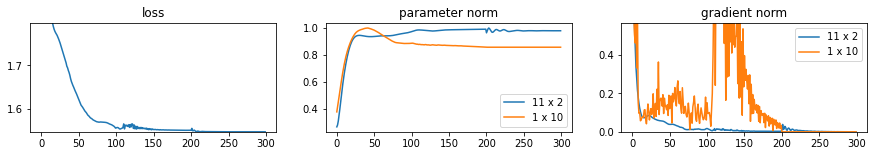

restart  7/10: 100%|██████████| 300/300 [00:01<00:00, 175.41it/s, max=3.9629, cur=1.4408]


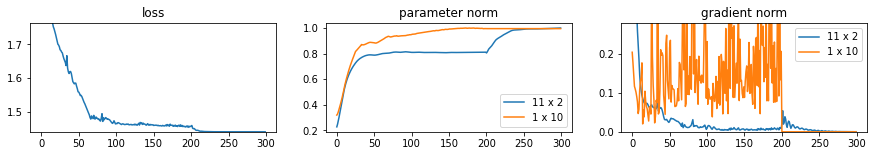

restart  8/10: 100%|██████████| 300/300 [00:01<00:00, 161.43it/s, max=3.8070, cur=1.4422]


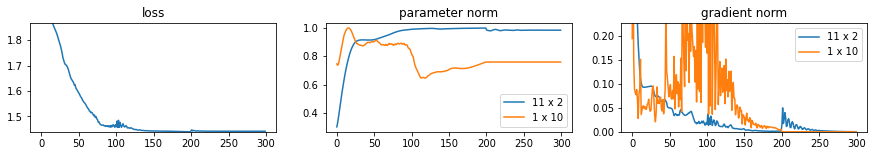

restart  9/10: 100%|██████████| 300/300 [00:01<00:00, 181.69it/s, max=3.6206, cur=1.4335]


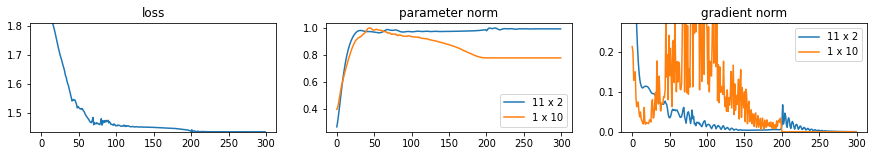

restart 10/10: 100%|██████████| 300/300 [00:01<00:00, 187.42it/s, max=4.5126, cur=1.4492]


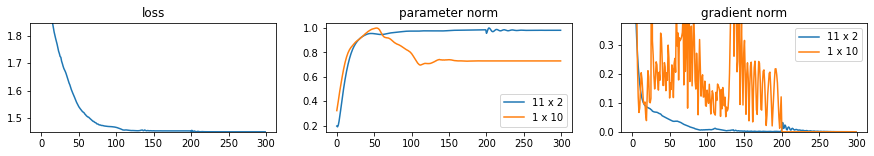

best loss = 1.4290
mean loss = 1.4774 +-0.0458


In [8]:
best_loss = np.inf
loss_curves = np.empty((n_restarts, n_epochs))
for r in range(n_restarts):
    # reset everything
    optimizer = torch.optim.Adam(paramwarp.parameters(), lr=lr)
    param_norm = []
    grad_norm = []
    train_losses = []
    resample_kernel = "linear"
    epoch_counter = tqdm.tqdm(range(n_epochs), desc=f"restart {(r+1):2d}/{n_restarts:2d}")

    # initialize parameters
    _ = paramwarp.apply(nwarp.reset_parameters)

    # perform training
    paramwarp.train()
    for epoch in epoch_counter:
        optimizer.zero_grad()
        
        if epoch == n_epochs - n_epochs_hard:
            optimizer = torch.optim.Adam(paramwarp.parameters(), lr=lr)
            resample_kernel = "integer"

        param_hat_train = paramwarp(x_train, resample_kernel=resample_kernel)
        nllloss = -model(x_train, param_hat_train).mean()
        loss = nllloss
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        param_norm.append([sl.norm(p.detach()) for p in paramwarp.parameters() if len(p)>0])
        grad_norm.append([sl.norm(p.grad.detach()) for p in paramwarp.parameters() if len(p)>0])
        epoch_counter.set_postfix({"max": f"{max(train_losses):.4f}", "cur": f"{loss.item():.4f}"})

    loss_curves[r,:] = train_losses
    if train_losses[-1] < best_loss:
        best_paramwarp_state = deepcopy(paramwarp.state_dict())
        best_loss = train_losses[-1]

    if show_plots:
        plt.figure(figsize=(15,2))
        plt.subplot(131)
        plt.title("loss")
        plt.ylim(np.min(train_losses), np.percentile(train_losses, 95))
        plt.plot(train_losses)

        plt.subplot(132)
        plt.title("parameter norm")
        lines = plt.plot(np.array(param_norm)/np.array(param_norm).max(axis=0))
        plt.legend(lines, [" x ".join([str(d) for d in p.size()]) for p in paramwarp.parameters() if len(p)>0])

        plt.subplot(133)
        plt.title("gradient norm")
        normalized_grad_norm = np.array(grad_norm)/np.array(grad_norm).max(axis=0)
        lines = plt.plot(normalized_grad_norm)
        plt.legend(lines, [" x ".join([str(d) for d in p.size()]) for p in paramwarp.parameters() if len(p)>0])
        plt.ylim(np.min(normalized_grad_norm), np.percentile(normalized_grad_norm, 95))

        plt.show()

paramwarp.eval()
paramwarp.load_state_dict(best_paramwarp_state)
print(f"best loss = {best_loss:.4f}")
print(f"mean loss = {loss_curves[:,-1].mean():.4f} +-{loss_curves[:,-1].std():.4f}")

### Evaluation

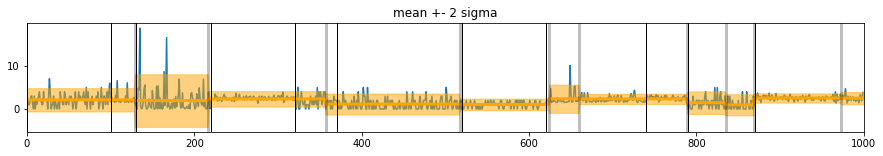

In [21]:
param_hat_train = paramwarp(x_train, resample_kernel=resample_kernel)
cps_hat = paramwarp._almat.sum(dim=1).cumsum(dim=1).squeeze()[:-1]

plt.figure(figsize=(15,2))
plt.xlim(0,T)
plt.plot(x_train[0,:,0], alpha=1, zorder=-1)
plt.fill_between(x=range(T),
                 y1=param_hat_train[0,:,0].detach()-2*torch.sqrt(torch.exp(param_hat_train[0,:,1].detach())),
                 y2=param_hat_train[0,:,0].detach()+2*torch.sqrt(torch.exp(param_hat_train[0,:,1].detach())),
                color='orange', alpha=0.5)
plt.plot(param_hat_train[0,:,0].detach(), color='orange', lw=3)
for cp in cps_hat:
    plt.axvline(cp, lw=3, color='black', alpha=0.25)
for cp in cps:
    plt.axvline(cp, lw=1, color='black')
plt.title('mean +- 2 sigma')
plt.show()

In [22]:
print(f'd_hdf = {hausdorff(cps[1:-1], cps_hat):.0f}')
print(f'd_fro = {frobenius(cps[1:-1], cps_hat):.2f}')

d_hdf = 103
d_fro = 2.54
